In [1]:
import pandas as pd
from ast import literal_eval
import numpy as np
np.seterr(all="raise")

today = "2019-11-06"

df = pd.read_parquet(f"out/{today}-1d-test.parquet")
df["total_params1"] = df["shape1[0]"]# * df["shape1[1]"]
df["total_params2"] = df["shape2[0]"]# * df["shape2[1]"]
print(len(df))
df.tail()

60000


,shape1[0],shape2[0],mode,seed,fft_time,direct_time,total_params1,total_params2
59995,45,949,full,19998,0.000166,0.000067,45,949
59996,45,949,same,19998,0.000179,0.000518,45,949
59997,23489,45440,valid,19999,0.003046,0.099871,23489,45440
59998,23489,45440,full,19999,0.002872,0.213914,23489,45440
59999,23489,45440,same,19999,0.002797,13.728895,23489,45440


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("..")
from common import _fftconv_faster_test as _fftconv_faster

In [4]:

def estimate_faster_method(row):
    x_shape = (row["shape1[0]"], )
    h_shape = (row["shape2[0]"], )
    mode = row["mode"]
    return _fftconv_faster(x_shape, h_shape, mode, test=False)

In [5]:
fft_faster = df["fft_time"] < df["direct_time"]
df["faster"] = ""
df.loc[fft_faster, "faster"] = "fft"
df.loc[~fft_faster, "faster"] = "direct"

df["faster_est"] = df.apply(estimate_faster_method, axis=1)

df["correct"] = (df.faster == df.faster_est)
acc = df["correct"].sum() / len(df)
print(f"Predicted fastest method {100 * acc:0.2f}% of the time")

Predicted fastest method 89.67% of the time


**Goal for accuracy on predicting fastest**: >90% -- that's the performance seen with code from SciPy 1.3 (after uncommenting `_get_constant` function above)

In [6]:
idx = (df["mode"] == "same") & (df["shape1[0]"] < df["shape2[0]"])
df["cond"] = "a"
df.loc[idx, "cond"] = "sp_conv"
idx = (df["mode"] == "same") & (df["shape1[0]"] >= df["shape2[0]"])
df.loc[idx, "cond"] = "np_conv"

In [7]:
df.groupby(["mode", "cond"])["correct"].count()

mode   cond   
full   a          20000
same   np_conv    10058
       sp_conv     9942
valid  a          20000
Name: correct, dtype: int64

In [10]:
t = show = df.pivot_table(
    columns="cond",
    index="mode",
    values="correct",
    aggfunc=np.mean,
).reset_index()
t = t.melt(id_vars=["mode"]).dropna()
print(t)
# t[t.cond != "a"]

    mode     cond     value
0   full        a  0.884900
2  valid        a  0.937000
4   same  np_conv  0.923842
7   same  sp_conv  0.811909


In [11]:
wrong_idx = df.faster != df.faster_est
wrong =  df[wrong_idx].copy()
wrong["ratio"] = wrong.fft_time / wrong.direct_time
idx = wrong.ratio < 1
wrong.loc[idx, "ratio"] = 1 / wrong.loc[idx, "ratio"]

vals = wrong.copy()
vals.sort_values(by="direct_time", inplace=True)
vals.tail(n=10)

,shape1[0],shape2[0],mode,seed,fft_time,direct_time,total_params1,total_params2,faster,faster_est,correct,cond,ratio
10427,28,74823,same,3475,0.002825,0.021310,28,74823,fft,direct,False,sp_conv,7.543889
6521,30,72897,same,2173,0.003037,0.021894,30,72897,fft,direct,False,sp_conv,7.208415
40916,25,89099,same,13638,0.003192,0.022532,25,89099,fft,direct,False,sp_conv,7.059083
32330,24,95793,same,10776,0.003337,0.023390,24,95793,fft,direct,False,sp_conv,7.009431
41003,28,84623,same,13667,0.004239,0.024287,28,84623,fft,direct,False,sp_conv,5.730003
37541,29,81257,same,12513,0.003553,0.024616,29,81257,fft,direct,False,sp_conv,6.928797
4724,26,91399,same,1574,0.004209,0.025054,26,91399,fft,direct,False,sp_conv,5.952082
33164,28,83948,same,11054,0.003214,0.025643,28,83948,fft,direct,False,sp_conv,7.978709
20990,30,89938,same,6996,0.003333,0.026413,30,89938,fft,direct,False,sp_conv,7.925526
32465,30,92313,same,10821,0.004017,0.028138,30,92313,fft,direct,False,sp_conv,7.004095


In [12]:
vals["correct"] = (vals["faster"] == vals["faster_est"])#.astype(float)
print(vals["faster"].unique())
print(vals["faster_est"].unique())
print(vals.correct.unique())

vals.pivot_table(
    index="mode",
    values="correct",
    aggfunc=np.mean,
)

['direct' 'fft']
['fft' 'direct']
[False]


,correct
mode,
full,False
same,False
valid,False


In [13]:
vals.ratio.max()

10.105960264900663

In [14]:
vals.direct_time.min()

-0.022168636322021484

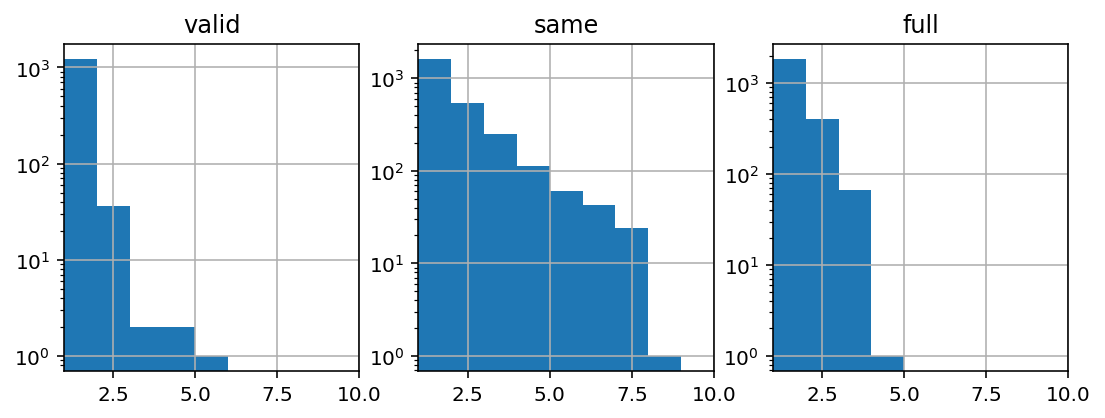

In [15]:
lims = range(int(wrong.ratio.max() + 1))

import matplotlib.pyplot as plt
w = 3
fig, axs = plt.subplots(ncols=3, figsize=(3*w, w))
for mode, ax in zip(["valid", "same", "full"], axs):
    show = wrong[wrong["mode"] == mode]
    ax = show.ratio.hist(bins=lims, ax=ax)
    _ = ax.set_xlim(1, 10)
    _ = ax.set_title(mode)
    _ = ax.set_xlim(1, 10)
    _ = ax.set_yscale("log")

**Goal for this histogram:** `ratio.max() < 5` approximately. That's the performance with SciPy 1.3 (again, after un-commenting `_get_constants` above).

In [16]:
i = (df["mode"] == "valid") & (df.faster_est == "direct")
df[i]

,shape1[0],shape2[0],mode,seed,fft_time,direct_time,total_params1,total_params2,faster,faster_est,correct,cond
3,230,5433,valid,1,0.000448,0.000371,230,5433,direct,direct,True,a
6,281,3,valid,2,0.000236,0.000032,281,3,direct,direct,True,a
15,30,26021,valid,5,0.001302,0.000763,30,26021,direct,direct,True,a
18,32765,95,valid,6,0.001672,0.001298,32765,95,direct,direct,True,a
21,6,10106,valid,7,0.000515,0.000045,6,10106,direct,direct,True,a
...,...,...,...,...,...,...,...,...,...,...,...,...
59982,8688,3,valid,19994,0.000996,0.000038,8688,3,direct,direct,True,a
59985,14,266,valid,19995,0.000170,0.000032,14,266,direct,direct,True,a
59988,162,5,valid,19996,0.000161,0.000026,162,5,direct,direct,True,a
59991,6,3,valid,19997,0.000146,0.000024,6,3,direct,direct,True,a


In [17]:
for mode in ["full", "valid", "same"]:
    print(mode)
    for i in np.linspace(1, 12 + 1, num=200):
        idx = wrong["mode"] == mode
        prob = (wrong[idx].ratio <= i).sum() / idx.sum()
        msg = f"P(ratio <= {i:0.2f}) = {100 * prob:0.1f}%"
        if 0.940 <= prob <= 0.960:
            print(msg)

full
P(ratio <= 2.75) = 94.3%
P(ratio <= 2.81) = 95.2%
P(ratio <= 2.87) = 95.9%
valid
P(ratio <= 1.84) = 94.9%
P(ratio <= 1.90) = 95.6%
same
P(ratio <= 4.74) = 94.2%
P(ratio <= 4.80) = 94.2%
P(ratio <= 4.86) = 94.3%
P(ratio <= 4.92) = 94.7%
P(ratio <= 4.98) = 94.9%
P(ratio <= 5.04) = 95.1%
P(ratio <= 5.10) = 95.2%
P(ratio <= 5.16) = 95.3%
P(ratio <= 5.22) = 95.3%
P(ratio <= 5.28) = 95.5%
P(ratio <= 5.34) = 95.6%
P(ratio <= 5.40) = 95.8%


In [15]:
for mode in ["full", "valid", "same"]:
    print(mode)
    for i in np.linspace(1, 12 + 1, num=200):
        idx = wrong["mode"] == mode
        prob = (wrong[idx].ratio <= i).sum() / idx.sum()
        msg = f"P(ratio <= {i:0.2f}) = {100 * prob:0.1f}%"
        if 0.940 <= prob <= 0.960:
            print(msg)

full
P(ratio <= 2.75) = 94.3%
P(ratio <= 2.81) = 95.2%
P(ratio <= 2.87) = 95.9%
valid
P(ratio <= 1.84) = 94.9%
P(ratio <= 1.90) = 95.6%
same
P(ratio <= 4.74) = 94.2%
P(ratio <= 4.80) = 94.2%
P(ratio <= 4.86) = 94.3%
P(ratio <= 4.92) = 94.7%
P(ratio <= 4.98) = 94.9%
P(ratio <= 5.04) = 95.1%
P(ratio <= 5.10) = 95.2%
P(ratio <= 5.16) = 95.3%
P(ratio <= 5.22) = 95.3%
P(ratio <= 5.28) = 95.5%
P(ratio <= 5.34) = 95.6%
P(ratio <= 5.40) = 95.8%


valid a 1260
same np_conv 766
same sp_conv 1870
full a 2302


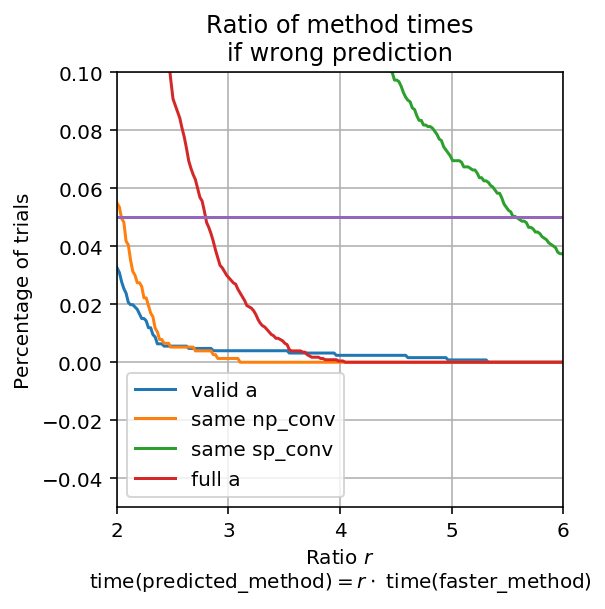

In [24]:
lims = np.linspace(1, int(wrong.ratio.max() + 1), num=500)

import matplotlib.pyplot as plt
w = 4
fig, ax = plt.subplots(figsize=(w, w))
for mode in ["valid", "same", "full"]:
    conds = "a" if mode != "same" else ["np_conv", "sp_conv"]
    for cond in conds:
        idx = (wrong["mode"] == mode) & (wrong["cond"] == cond)
        print(mode, cond, idx.sum())
        show = wrong[(wrong["mode"] == mode) & (wrong["cond"] == cond)]
        cdf = {i: (show.ratio <= i).sum() / len(show) for i in lims}
        ax = (1 - pd.Series(cdf)).plot(ax=ax, label=mode + " " + cond)
ax.grid()
ax.legend(loc="best")
# ax.set_yscale("log")
# _ = ax.set_ylim(0.5, 1)
_ = ax.set_title("Ratio of method times\nif wrong prediction")
_ = ax.set_ylabel("Percentage of trials")
_ = ax.set_xlabel("Ratio $r$\n" + r"time(predicted_method)$= r \cdot$ time(faster_method)")
_ = ax.set_xlim(2, 6)
_ = ax.set_ylim(None, 0.1)
_ = ax.plot(ax.get_xlim(), [0.05, 0.05])

DIR = "/Users/scott/Desktop/"
plt.savefig(DIR + "1d-wrong-factor.png", bbox_inches="tight")

In [19]:
df.columns

Index(['shape1[0]', 'shape2[0]', 'mode', 'seed', 'fft_time', 'direct_time',
       'total_params1', 'total_params2', 'faster', 'faster_est', 'correct',
       'cond'],
      dtype='object')

FFT >2x faster for 23.60% of tests in mode=full and cond=np_conv
FFT >2x faster for 23.60% of tests in mode=full and cond=sp_conv
FFT >2x faster for 20.32% of tests in mode=valid and cond=np_conv
FFT >2x faster for 20.32% of tests in mode=valid and cond=sp_conv
FFT >2x faster for 22.57% of tests in mode=same and cond=np_conv
FFT >2x faster for 64.31% of tests in mode=same and cond=sp_conv


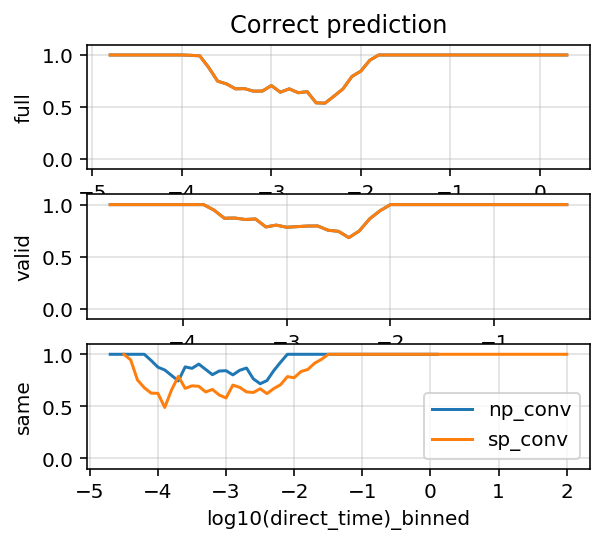

In [20]:
import matplotlib.pyplot as plt

i = (df.direct_time <= 0) | (df.fft_time <= 0)
show = df[~i].copy()
show["log_ratio"] = np.log2(show["fft_time"] / show["direct_time"]);
show = show[["log_ratio", "correct", "mode", "cond", "direct_time"]].copy()
show["log_ratio_binned"] = np.round(show.log_ratio, decimals=1)

def log_round(x, decimals=0):
    return 2 ** np.round(np.log2(x), decimals=decimals)

show["direct_time_binned"] = log_round(show.direct_time, decimals=1)
show["log10(direct_time)_binned"] = np.log10(show.direct_time).round(decimals=1)

x_key = "direct_time_binned"
x_key = "log10(direct_time)_binned"
y_key = "correct"

w = 3
fig, axs = plt.subplots(nrows=3, figsize=(1.5 * w, 1.3 * w))

for i, (ax, mode) in enumerate(zip(axs, ["full", "valid", "same"])):
    for cond in ["np_conv", "sp_conv"]:
        if mode != "same":
            s = show[show["mode"] == mode]
        else:
            idx = (show["mode"] == mode) & (show["cond"] == cond)
            s = show[idx]
        frac_fft_faster = (s.log_ratio < -1).sum() / len(s)
        print(f"FFT >2x faster for {100 * frac_fft_faster:0.2f}% of tests in mode={mode} and cond={cond}")
        correct_predictions = s.pivot_table(
            index=x_key,
            values=y_key,
            aggfunc=np.mean
        )
        label = mode if mode != "same" else cond
        _ = ax.plot(correct_predictions, label=label)
        _ = ax.set_ylim(-0.1, 1.1)
        _ = ax.set_ylabel(mode)
        _ = ax.grid(alpha=0.4)
#         _ = ax.set_xscale("log")
        if i == 2:
            _ = ax.set_xlabel(x_key)
            _ = ax.legend(loc="best")
axs[0].set_title("Correct prediction")
plt.savefig(DIR + "1d-direct-time-correct.png", bbox_inches="tight")

FFT >2x faster for 23.60% of tests in mode=full and cond=np_conv
full


FFT >2x faster for 20.32% of tests in mode=valid and cond=np_conv
valid


FFT >2x faster for 22.57% of tests in mode=same and cond=np_conv
np_conv


FFT >2x faster for 64.31% of tests in mode=same and cond=sp_conv
sp_conv


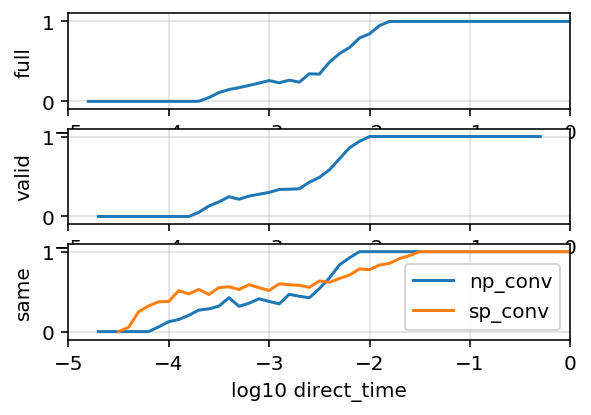

In [19]:
import matplotlib.pyplot as plt

i = (df.direct_time <= 0) | (df.fft_time <= 0)
show = df[~i].copy()
show["log_ratio"] = np.log2(show["fft_time"] / show["direct_time"]);
show = show[["log_ratio", "correct", "mode", "cond", "direct_time", "faster_est"]].copy()
show["log_ratio_binned"] = np.round(show.log_ratio, decimals=1)
show["log10(direct_time_binned)"] = np.round(np.log10(show.direct_time), decimals=1)

w = 3
fig, axs = plt.subplots(nrows=3, figsize=(1.5 * w, w))

for i, (ax, mode) in enumerate(zip(axs, ["full", "valid", "same"])):
    for cond in ["np_conv", "sp_conv"]:
        if mode != "same":
            s = show[show["mode"] == mode].copy()
        else:
            idx = (show["mode"] == mode) & (show["cond"] == cond)
            s = show[idx].copy()
        if "sp" in cond and mode != "same":
            continue
        frac_fft_faster = (s.log_ratio < -1).sum() / len(s)
        s["fft_chosen"] = s.faster_est == "fft"
        print(f"FFT >2x faster for {100 * frac_fft_faster:0.2f}% of tests in mode={mode} and cond={cond}")
        correct_predictions = s.pivot_table(
            #index="log_ratio_binned",
            index="log10(direct_time_binned)",
            values="fft_chosen",
            aggfunc=np.mean
        )
        label = mode if mode != "same" else cond
        print(label)
        ax.plot(correct_predictions, label=label)
#         _ = ax.set_xlim(-4, 4)
        _ = ax.set_ylim(-0.1, 1.1)
        _ = ax.legend(loc="best")
#         _ = ax.plot([0, 0], ax.get_ylim())
        _ = ax.set_ylabel(mode)
        _ = ax.grid(which="both", alpha=0.4)
        _ = ax.set_xlim(-5, 0)
        ax.legend_.remove()
        if i == 2:
            _ = ax.set_xlabel("log10 direct_time")
            ax.legend(loc="best")
#             ax.set_xlim(-4, -3)
# plt.savefig(DIR + "1d-direct-time-correct.png", bbox_inches="tight")

1D w/ np.convolve: okay
1D w/ sp.convolve: not okay
2D: not okay

In [20]:
df.columns

Index(['shape1[0]', 'shape2[0]', 'mode', 'seed', 'fft_time', 'direct_time',
       'total_params1', 'total_params2', 'faster', 'faster_est', 'correct',
       'cond'],
      dtype='object')

In [21]:
idx = (df["mode"] == "same") & (df.cond == "np_conv")
print(df.loc[idx, "faster_est"].value_counts())
print(df.loc[idx, "faster"].value_counts())

idx = (df["mode"] == "same") & (df.cond == "sp_conv")
print(df.loc[idx, "faster_est"].value_counts())
print(df.loc[idx, "faster"].value_counts())

direct    6981
fft       3077
Name: faster_est, dtype: int64
direct    6827
fft       3231
Name: faster, dtype: int64
fft       6655
direct    3287
Name: faster_est, dtype: int64
fft       7283
direct    2659
Name: faster, dtype: int64


FFT >2x faster for 23.60% of tests in mode=full
FFT >2x faster for 20.32% of tests in mode=valid
FFT >2x faster for 43.32% of tests in mode=same


Text(0.5, 0, 'number')

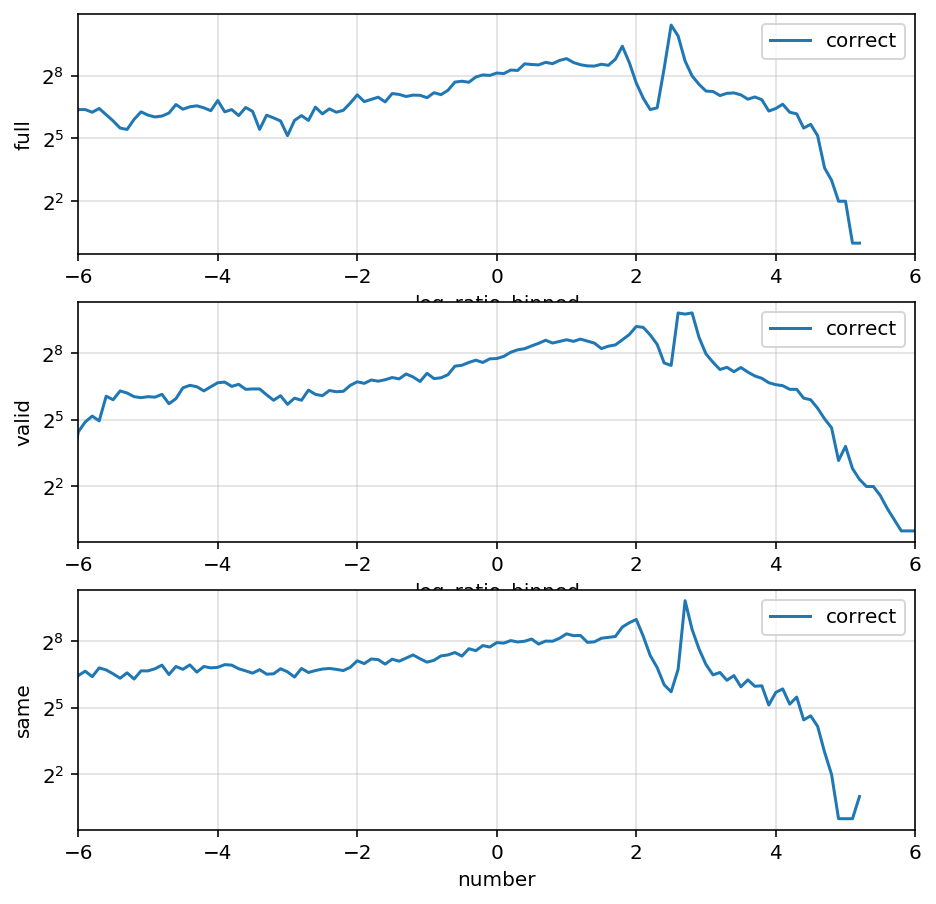

In [22]:
import matplotlib.pyplot as plt

i = (df.direct_time <= 0) | (df.fft_time <= 0)
show = df[~i].copy()
show["log_ratio"] = np.log2(show["fft_time"] / show["direct_time"]);
show = show[["log_ratio", "correct", "mode"]].copy()
show["log_ratio_binned"] = np.round(show.log_ratio, decimals=1)

w = 5
fig, axs = plt.subplots(nrows=3, figsize=(1.5 * w, 1.5 * w))

for i, (ax, mode) in enumerate(zip(axs, ["full", "valid", "same"])):
    s = show[show["mode"] == mode]
    frac_fft_faster = (s.log_ratio < -1).sum() / len(s)
    print(f"FFT >2x faster for {100 * frac_fft_faster:0.2f}% of tests in mode={mode}")
    num = s.pivot_table(
        index="log_ratio_binned",
        values="correct",
        aggfunc=len,
    )
    _ = ax = num.plot(ax=ax)
    ax.set_yscale("log", basey=2)
    _ = ax.set_xlim(-6, 6)
#     _ = ax.set_ylim(-0.1, 1.1)
#     _ = ax.plot([0, 0], ax.get_ylim())
#     _ = ax.set_ylabel(mode)
    _ = ax.set_ylabel(mode)
    _ = ax.grid(alpha=0.4)
    if i == 2:
        ax.set_xlabel("number")
#         ax.text(-3, -0.5, "← FFT faster")
#         ax.text(2, -0.5, "direct faster →")
#     else:
#         ax.legend_.remove()

In [23]:
idx = (wrong["mode"] == "same") & (wrong["direct_time"] < 10**-3)
shapes = ["shape1[0]", "shape2[0]"]
wrong.loc[idx, shapes]

,shape1[0],shape2[0]
23,6,10106
50,30,697
59,8,8320
68,26,452
131,9,1705
...,...,...
59834,1404,758
59843,1301,400
59906,93,261
59927,50,115


In [24]:
df.groupby(["mode", "cond"])["faster_est"].value_counts()

mode   cond     faster_est
full   a        direct        15534
                fft            4466
same   np_conv  direct         6981
                fft            3077
       sp_conv  fft            6655
                direct         3287
valid  a        direct        15171
                fft            4829
Name: faster_est, dtype: int64

In [25]:
df.groupby(["mode", "cond"])["faster"].value_counts()

mode   cond     faster
full   a        direct    13246
                fft        6754
same   np_conv  direct     6827
                fft        3231
       sp_conv  fft        7283
                direct     2659
valid  a        direct    14229
                fft        5771
Name: faster, dtype: int64